## Análise Exploratória de Dados (AED ou EDA)

**esse notebook tem como objetivo demonstrar algumas formar de explorar dados com o objetivo de extrair insights sobre o tema trabalhado**

In [0]:
#!pip install ydata-profiling

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [0]:
def box_plot(data, x = 'bmi'):
    def add_values(bp, ax):
        """ This actually adds the numbers to the various points of the boxplots"""
        for element in ['whiskers', 'medians', 'caps']:
            for line in bp[element]:
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    x_line_center = x_l + (x_r - x_l)/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax.text(x_line_center, y_line_center, # Position
                            '%.2f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='center', # Centered vertically with line 
                            fontsize=12, backgroundcolor="white")

    fig, axes = plt.subplots(1, figsize=(4, 8))

    red_diamond = dict(markerfacecolor='r', marker='D')

    bp_dict = data.boxplot(column = x, 
                             grid=True, 
                             figsize=(4, 8), 
                             ax=axes, 
                             vert = True, 
                             notch=False, 
                             widths = 0.7, 
                             showmeans = True, 
                             whis = 1.5,
                             flierprops = red_diamond,
                             boxprops= dict(linewidth=3.0, color='black'),
                             whiskerprops=dict(linewidth=3.0, color='black'),
                             return_type = 'dict')

    add_values(bp_dict, axes)

    plt.title(f'{x.capitalize()} Boxplot', fontsize=16)
    plt.ylabel(f'{x.capitalize()}', fontsize=14)
    plt.show()
    
    skew = data[x].skew()
    Q1 = data[x].quantile(0.25)
    Q3 = data[x].quantile(0.75)
    IQR = Q3 - Q1
    total_outlier_num = ((data[x] < (Q1 - 1.5 * IQR)) | (data[x] > (Q3 + 1.5 * IQR))).sum()
    print(f'Mean {x.capitalize()} = {data[x].mean()}')
    print(f'Median {x.capitalize()} = {data[x].median()}')
    print(f'Skewness of {x}: {skew}.')
    print(f'Total number of outliers in {x} distribution: {total_outlier_num}.')

## Buscar os dados desejados

In [0]:
df = spark.table("default.dados_cliente_perfil_custos").toPandas()
df

,client_id,age,sex,bmi,children,smoker,region,charges
0,1976,19,female,27.900,0,yes,southwest,16884.92400
1,7790,18,male,33.770,1,no,southeast,1725.55230
2,5224,28,male,33.000,3,no,southeast,4449.46200
3,5413,33,male,22.705,0,no,northwest,21984.47061
4,1482,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,5482,50,male,30.970,3,no,northwest,10600.54830
1334,8693,18,female,31.920,0,no,northeast,2205.98080
1335,2760,18,female,36.850,0,no,southeast,1629.83350
1336,4388,21,female,25.800,0,no,southwest,2007.94500


## EDA

In [0]:
profile = ProfileReport(df, title="check_data_quality")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

`ICM`

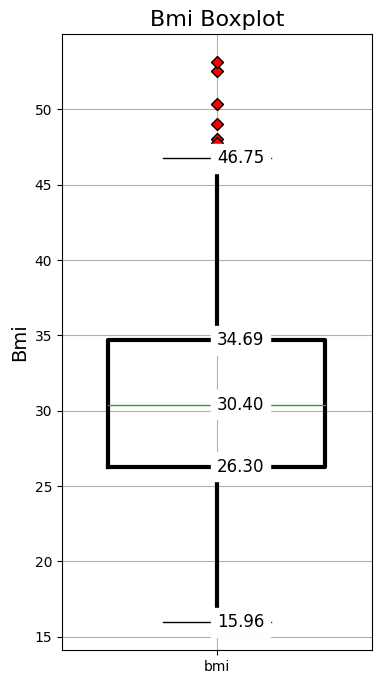

Mean Bmi = 30.66339686098655
Median Bmi = 30.4
Skewness of bmi: 0.2840471105987448.
Total number of outliers in bmi distribution: 9.


In [0]:
box_plot(df, "bmi")

In [0]:
df[df['bmi'] == df['bmi'].max()]

,client_id,age,sex,bmi,children,smoker,region,charges
1317,6324,18,male,53.13,0,no,southeast,1163.4627


In [0]:
df['charges'].mean(), df['charges'].median()

(13270.422265141257, 9382.033)

**Observações:**

- A distribuição do IMC do segurado segue aproximadamente uma distribuição normal com Média de 30,66 e Mediana de 30,4.
- Há um total de 9 outliers distribuição do IMC, todos no lado superior. O maior IMC observado é 53,13.
- A pessoa com o IMC mais elevado é também uma das mais jovens (homem, 18 anos). Paga menos seguro do que a média e mediana.


`Valores de cobrança`

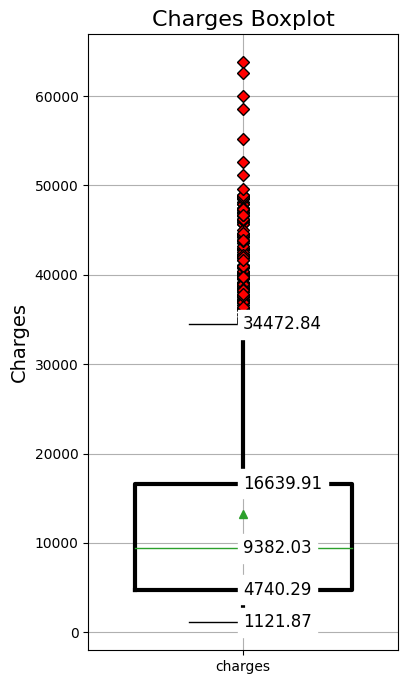

Mean Charges = 13270.422265141257
Median Charges = 9382.033
Skewness of charges: 1.5158796580240388.
Total number of outliers in charges distribution: 139.


In [0]:
box_plot(df, "charges")

In [0]:
df[df['charges'] == df['charges'].max()]

,client_id,age,sex,bmi,children,smoker,region,charges
543,9491,54,female,47.41,0,yes,southeast,63770.42801


In [0]:
df[df['charges'] == df['charges'].min()]

,client_id,age,sex,bmi,children,smoker,region,charges
940,7429,18,male,23.21,0,no,southeast,1121.8739


In [0]:
df[df['bmi'] == df['bmi'].max()]

,client_id,age,sex,bmi,children,smoker,region,charges
1317,6324,18,male,53.13,0,no,southeast,1163.4627


**Observações:**

- A distribuição dos valores de cada segurado tem média de 13.270,4223 e mediana de 9.382,033. O menor valor cobrado é 1121,8739 e o maior valor cobrado é 63770,42801.
- De um total de 1.338 segurados, há um total de 139 outliers.
- O segurado com maior valor de seguro é mulher de 54 anos, fumante e com IMC elevado (indicando obesidade).
- A pessoa com o IMC mais elevado é também uma das mais jovens (homem, 18 anos, não fumante).

`Dependentes`

In [0]:
df.groupby("children")["client_id"].count()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: client_id, dtype: int64

<Axes: xlabel='children', ylabel='count'>

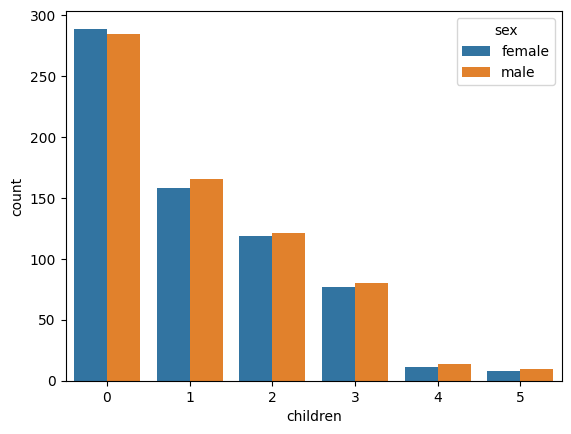

In [0]:
sns.countplot(x="children", hue="sex", data=df)

<Axes: xlabel='smoker', ylabel='count'>

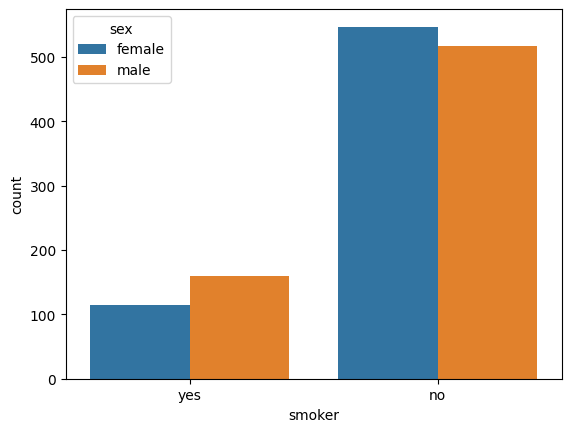

In [0]:
sns.countplot(x="smoker", hue="sex", data=df)

<Axes: xlabel='region', ylabel='count'>

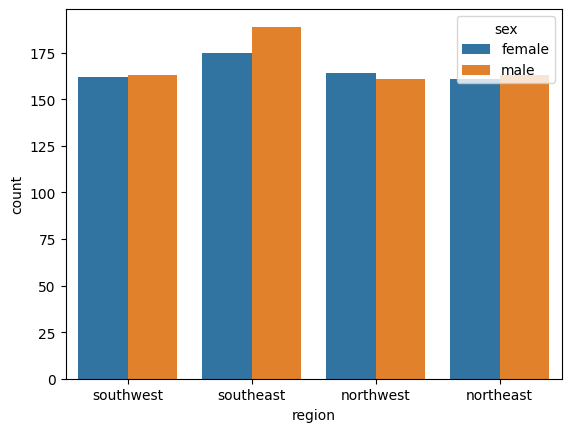

In [0]:
sns.countplot(x="region", hue="sex", data=df)

<Axes: xlabel='children', ylabel='charges'>

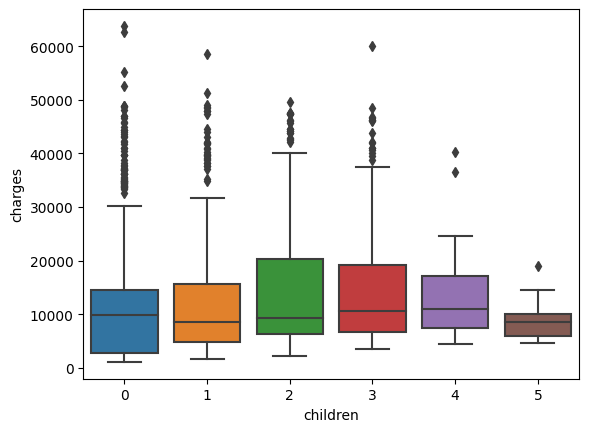

In [0]:
sns.boxplot(df, x="children", y="charges")

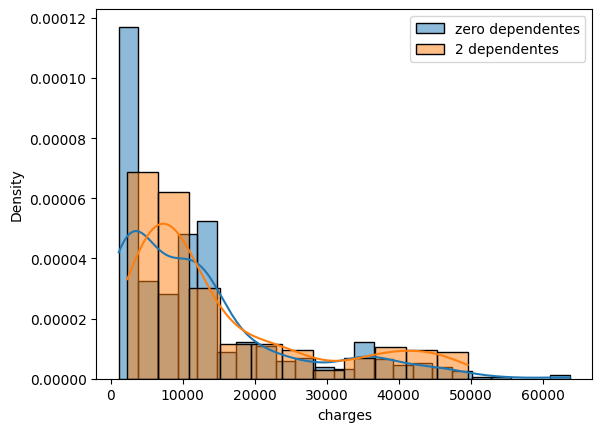

In [0]:
sns.histplot(df[df["children"]==0]["charges"], kde=True, stat="density", label="zero dependentes")
sns.histplot(df[df["children"]==2]["charges"], kde=True, stat="density", label="2 dependentes")
plt.legend()

`Fumantes`

In [0]:
df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [0]:
df.groupby(["smoker", "sex"])["client_id"].count()

smoker  sex   
no      female    547
        male      517
yes     female    115
        male      159
Name: client_id, dtype: int64

In [0]:
df.groupby(["sex", "smoker"])[["charges", "children"]].mean()

charges  children
sex    smoker                        
female no       8762.297300  1.087751
       yes     30678.996276  1.008696
male   no       8087.204731  1.092843
       yes     33042.005975  1.188679

**Observações:**

- Do total de 1.338 segurados, 274 (20,5%) são fumantes.
- Entre 274 fumantes, a proporção de homens (159) é maior que a de mulheres (115).
- O valor do seguro para fumantes é significativamente maior do que para os não fumantes.

`Região`

<Axes: xlabel='region', ylabel='charges'>

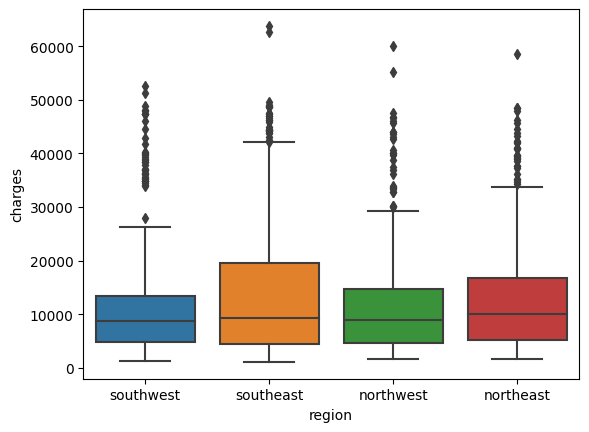

In [0]:
sns.boxplot(x="region", y="charges", data=df)

In [0]:
df.groupby(["region"])["charges"].agg(["mean", "median"]).reset_index().sort_values("region", ascending=False)

,region,mean,median
3,southwest,12346.937377,8798.593000
2,southeast,14735.411438,9294.131950
1,northwest,12417.575374,8965.795750
0,northeast,13406.384516,10057.652025


<Axes: xlabel='region', ylabel='bmi'>

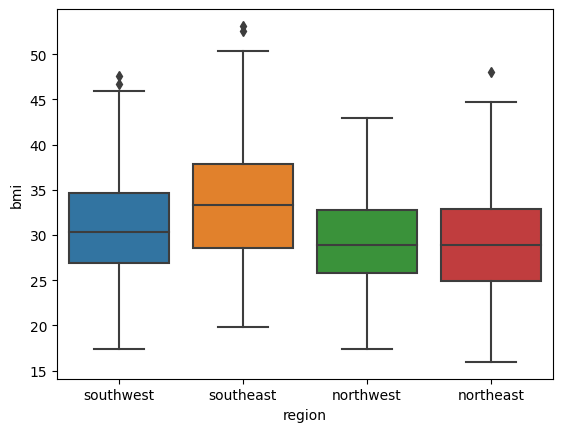

In [0]:
sns.boxplot(x="region", y="bmi", data=df)

<Axes: xlabel='region', ylabel='age'>

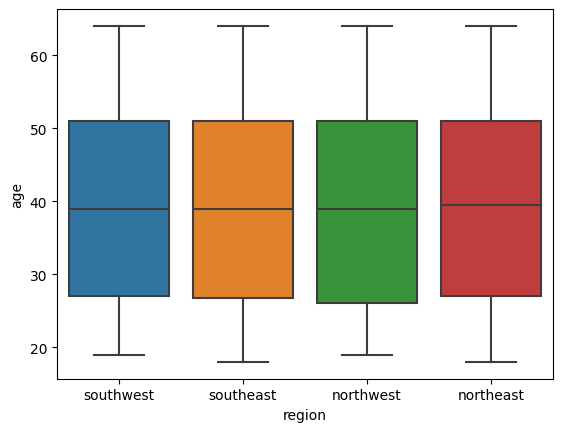

In [0]:
sns.boxplot(x="region", y="age", data=df)

<Axes: xlabel='region', ylabel='count'>

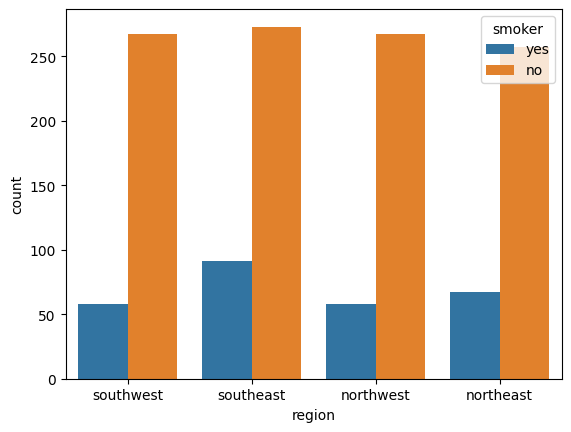

In [0]:
sns.countplot(x="region", hue="smoker", data=df)

**observações:**

- Região Sudeste (southeast) apresenta os maiores valores de gastos muito provavelmente porque apresenta maiores números de asegurados com alto IMC e maior quantidade de fumantes

`Idade`

<Axes: xlabel='age', ylabel='charges'>

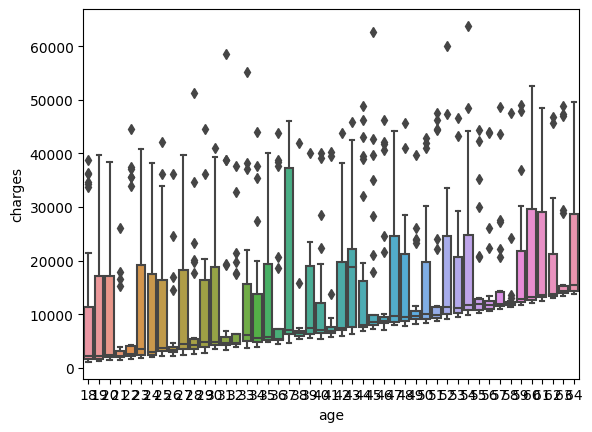

In [0]:
sns.boxplot(df, x="age", y="charges")

In [0]:
condicoes = [
    (df_age['age'] <=24),
    (df_age['age'] >=25) & (df['age'] <= 34),
    (df_age['age'] >=35) & (df['age'] <= 44),
    (df_age['age'] >=45) & (df['age'] <= 59),
    (df_age['age'] >=60),
]

In [0]:
valores = ['grupo1', 'grupo2', 'grupo3', 'grupo4', 'grupo5']

In [0]:
df['age_group'] = np.select(condicoes, valores)

In [0]:
df_age["age_group"].value_counts()

grupo4    415
grupo1    278
grupo2    271
grupo3    260
grupo5    114
Name: age_group, dtype: int64

<Axes: xlabel='age_group', ylabel='charges'>

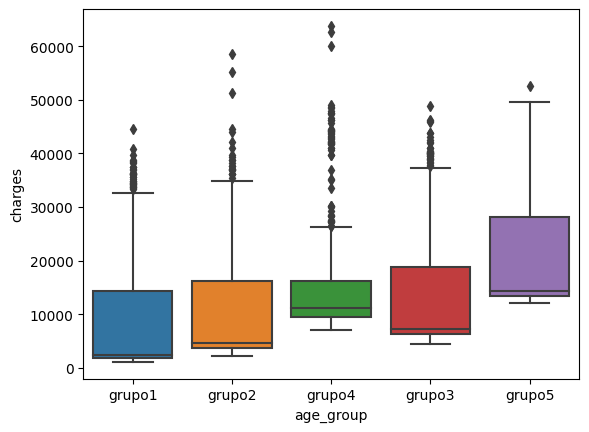

In [0]:
sns.boxplot(df_age, x="age_group", y="charges")

### Teste de hipoteses

Existe diferença no valor de seguro pago entre fumantes e não fumantes?

In [0]:
smokers = df[df['smoker'] == "yes"]
nonsmokers = df[df['smoker'] == "no"]
charge_smokers = smokers['charges']
charge_nonsmokers = nonsmokers['charges']

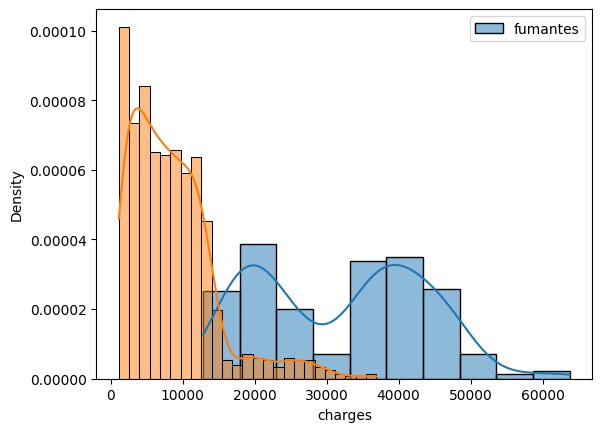

In [0]:
sns.histplot(smokers["charges"], kde=True, stat="density",label="fumantes")
sns.histplot(nonsmokers["charges"], kde=True, stat="density")
plt.legend()

In [0]:
estatistica, p_valor = mannwhitneyu(charge_smokers, charge_nonsmokers, alternative='two-sided')
# Imprimir os resultados
print(f'Estatística de teste: {estatistica}')
print(f'Valor p: {p_valor}')

# Testar a hipótese nula
alpha = 0.05
if p_valor < alpha:
    print('Rejeitamos a hipótese nula: As médias são estatisticamente diferentes.')
else:
    print('Não temos evidências para rejeitar a hipótese nula: As médias são estatisticamente iguais.')

Estatística de teste: 284133.0
Valor p: 5.270233444503571e-130
Rejeitamos a hipótese nula: As médias são estatisticamente diferentes.
